**Purpose:** Extract and plot the TIaaS stats

In [1]:
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import pycountry_convert as pc
import requests
import io

In [2]:
continents = {
    'NA': 'North America',
    'SA': 'South America', 
    'AS': 'Asia',
    'OC': 'Australia',
    'AF': 'Africa',
    'EU': 'Europe'
}

def get_continent(c):
    '''Extract continent name from a country code'''
    return continents[pc.country_alpha2_to_continent_code(c)]

def get_continents(c):
    '''Extract continent from country codes'''
    if '|' in c:
        cs = c.split('|')
        return '|'.join(set([get_continent(d) for d in cs]))
    else:
        return get_continent(c)

In [3]:
data_eu = requests.get('https://usegalaxy.eu/tiaas/numbers.csv').text.split('\n')
data_au = requests.get('https://usegalaxy.org.au/tiaas/numbers.csv').text.split('\n')[1:]

output = io.StringIO('\n'.join(data_eu) + "\n"+ '\n'.join(data_au))

df = (pd.read_csv(output, sep=',', index_col=0)
      # transform Y / N to True / False
     .replace("Y", True)
     .replace("N", False)
     .assign(
         start=lambda x: pd.to_datetime(x['start'], format='%Y-%m-%d'),
         end=lambda x: pd.to_datetime(x['end'], format='%Y-%m-%d'),
         month=lambda x: x['start'].dt.to_period('M'),
         year=lambda x: x['start'].dt.to_period('Y'),
         continent=lambda x: [get_continents(y) for y in x['location']]))

df

,start,end,location,use_gtn,attendance,month,year,continent
id,,,,,,,,
470,2022-02-22,2022-02-25,DE,True,40,2022-02,2022,Europe
454,2021-12-08,2021-12-09,FR,False,22,2021-12,2021,Europe
455,2021-12-10,2021-12-10,FR,False,22,2021-12,2021,Europe
447,2021-12-06,2021-12-06,GB,False,30,2021-12,2021,Europe
225,2019-09-23,2019-12-11,HU,True,7,2019-09,2019,Europe
...,...,...,...,...,...,...,...,...
38,2022-03-11,2022-06-03,AU,True,200,2022-03,2022,Australia
39,2022-03-11,2022-04-10,AU,True,110,2022-03,2022,Australia
40,2022-03-11,2022-06-03,AU,True,110,2022-03,2022,Australia


# General stats

Stats collected in timeframe

In [4]:
print(f"{min(df['start'])} - {max(df['start'])}")
print(f"Number of TIaaS events: {len(df)}")
print(f"Percentage using GTN: {sum(df.use_gtn)/len(df)*100:0.2f}%")
print(f"Total Participants: {sum(df.attendance)}")

paper_sentence = f"For example, between {min(df['start']).strftime('%B %Y')} and {max(df['end']).strftime('%B %Y')}, Galaxy Europe and Galaxy Australias has been used for more than {round(len(df), -1)} training events reaching more than {round(sum(df.attendance), -1)} students."
with open("../snippets/tiaas.tex", 'w') as handle:
    handle.write(paper_sentence)

2018-06-20 00:00:00 - 2022-04-27 00:00:00
Number of TIaaS events: 316
Percentage using GTN: 64.56%
Total Participants: 16374


# Evolution over the months

In [5]:
nb_per_months_df = (df
    .groupby(df.month)
    .agg({'start': ['count'], 'attendance': ['sum']}))
nb_per_months_df.columns = ['Events', 'Participants']
nb_per_months_df.tail()

,Events,Participants
month,,
2021-12,6,146
2022-01,5,74
2022-02,8,266
2022-03,17,4778
2022-04,4,80


Average number of events per months

In [6]:
sum(nb_per_months_df.Events)/len(nb_per_months_df)

6.869565217391305

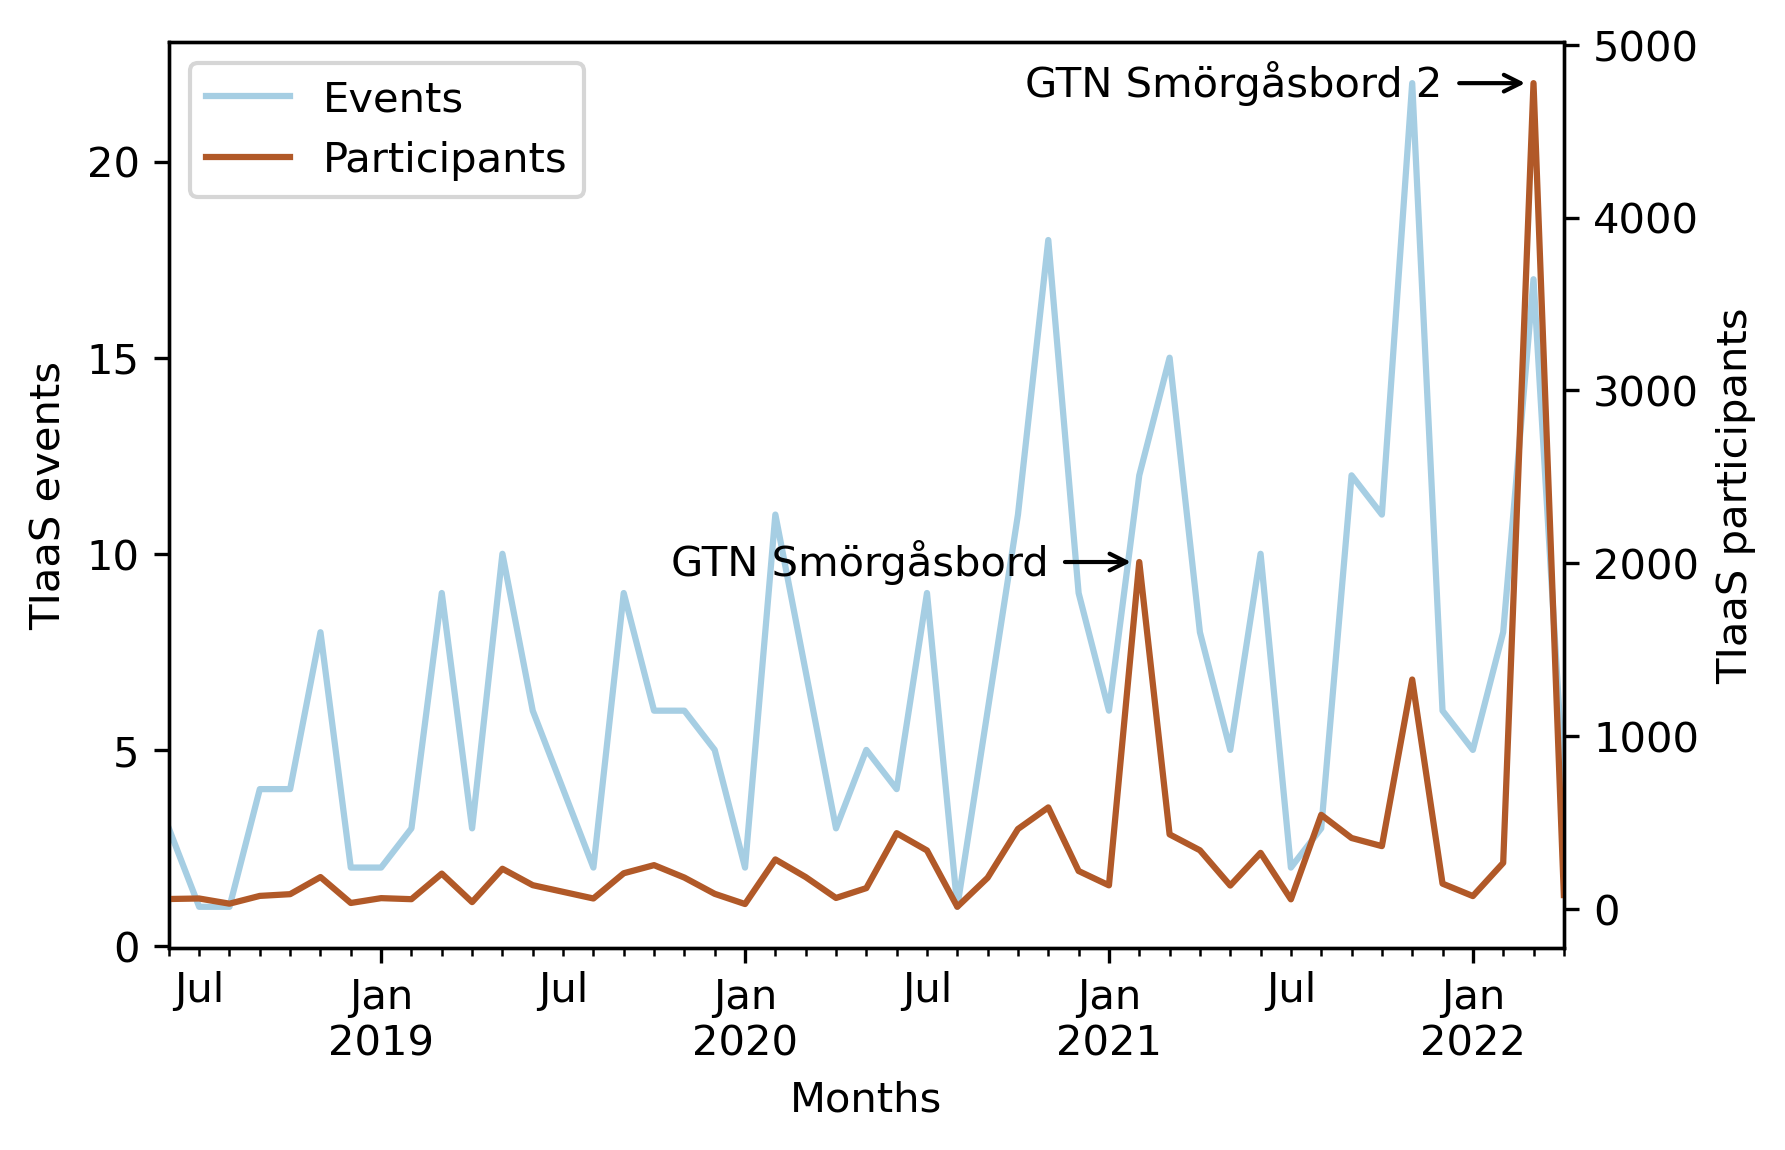

In [7]:
fig, ax = plt.subplots()
fig.set_dpi(300)

(nb_per_months_df
 .plot(colormap='Paired', secondary_y=['Participants'], mark_right=False, ax=ax)
)
ax.set_xlabel('Months')
ax.set_ylabel('TIaaS events')
ax.right_ax.set_ylabel('TIaaS participants')
plt.annotate(
    'GTN Smörgåsbord',
    xy=('2021-02-15', nb_per_months_df['Participants']['2021-02']),
    xycoords='data',
    xytext=('2020-11-01', nb_per_months_df['Participants']['2021-02']),
    arrowprops=dict(arrowstyle="->"),
    horizontalalignment='right',
    verticalalignment='center')
plt.annotate(
    'GTN Smörgåsbord 2',
    xy=('2022-03-15', nb_per_months_df['Participants']['2022-03']),
    xycoords='data',
    xytext=('2021-12-01', nb_per_months_df['Participants']['2022-03']),
    arrowprops=dict(arrowstyle="->"),
    horizontalalignment='right',
    verticalalignment='center')

plt.savefig('../images/tiaas-events.png', bbox_inches='tight')

# Location

In [8]:
nb_per_continents_df = (df
    .groupby(by='continent')
    .count()
    .filter(['start'])
    .rename(columns = {'start': 'Events'}))
nb_per_continents_df / len(df) * 100

,Events
continent,
Africa,3.164557
Asia,2.848101
Asia|Australia,0.316456
Australia,14.556962
Europe,71.518987
North America,6.962025
South America,0.632911


In [9]:
continent_year_event_df = pd.DataFrame(
    0,
    columns=list(df.continent.drop_duplicates().sort_values()) + ['Total'],
    index=['Total'] + list(df.year.drop_duplicates().sort_values(ascending=False)))
grouped_df = df.groupby(['year', 'continent'])
for g in grouped_df.groups:
    (y, c) = g
    continent_year_event_df[c][y] = len(grouped_df.get_group(g))
continent_year_event_df.loc['Total'] = continent_year_event_df.sum(axis=0)
continent_year_event_df['Total'] = continent_year_event_df.sum(axis=1)
continent_year_event_df

,Africa,Asia,Asia|Australia,Australia,Europe,North America,South America,Total
Total,10,9,1,46,226,22,2,316
2022,1,1,0,7,23,2,0,34
2021,3,6,1,28,63,11,0,112
2020,2,2,0,8,69,5,0,86
2019,3,0,0,2,52,3,1,61
2018,1,0,0,1,19,1,1,23


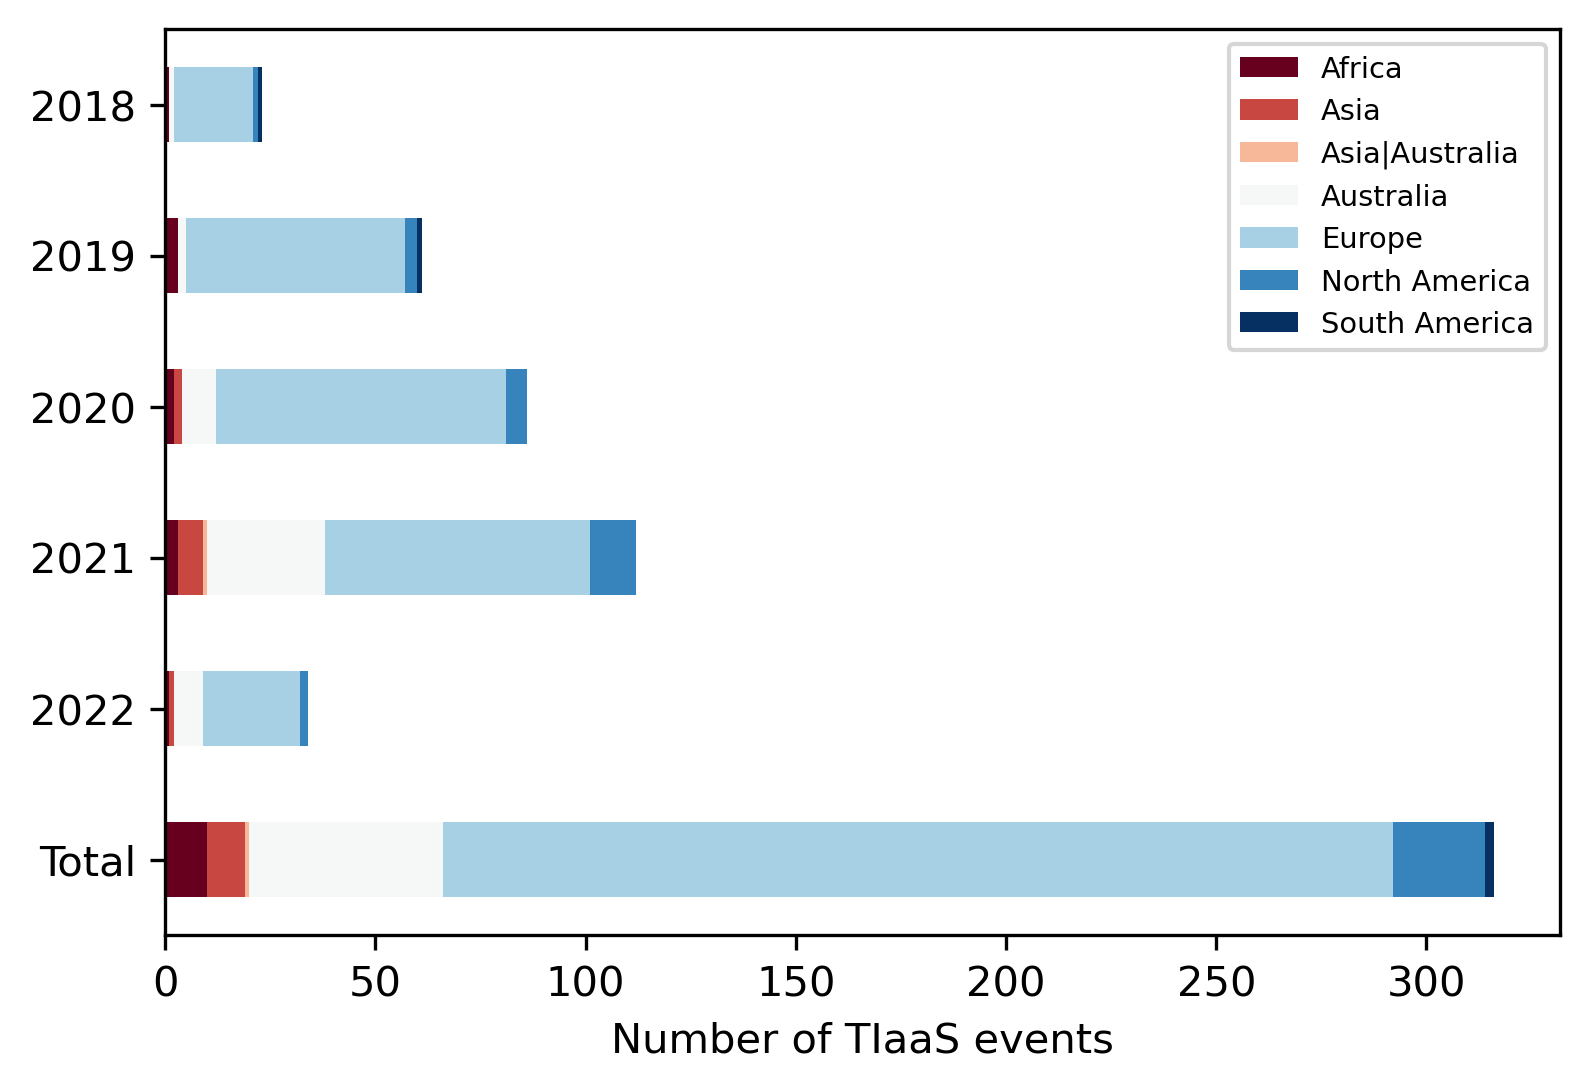

In [10]:
fig, ax = plt.subplots()
fig.set_dpi(300)
(continent_year_event_df
     .drop(['Total'], axis=1)
     .plot.barh(stacked=True, ax=ax, colormap='RdBu'))
plt.xlabel('Number of TIaaS events')
ax.legend(
    #loc='center left',
    #bbox_to_anchor=(1, 0.5),
    #frameon=False,
    fontsize='x-small')
plt.savefig('../images/tiaas-events-per-year.png', bbox_inches='tight')

In [11]:
continent_year_participants_df = pd.DataFrame(
    0,
    columns=list(df.continent.drop_duplicates().sort_values()) + ['Total'],
    index=['Total'] + list(df.year.drop_duplicates().sort_values(ascending=False)))
grouped_df = df.groupby(['year', 'continent'])
for g in grouped_df.groups:
    (y, c) = g
    continent_year_participants_df[c][y] = sum(grouped_df.get_group(g).attendance)
continent_year_participants_df.loc['Total'] = continent_year_participants_df.sum(axis=0)
continent_year_participants_df['Total'] = continent_year_participants_df.sum(axis=1)
continent_year_participants_df

,Africa,Asia,Asia|Australia,Australia,Europe,North America,South America,Total
Total,323,448,850,2000,12125,548,80,16374
2022,34,15,0,585,4519,45,0,5198
2021,48,353,850,1121,3604,241,0,6217
2020,124,80,0,260,2271,182,0,2917
2019,101,0,0,24,1332,40,20,1517
2018,16,0,0,10,399,40,60,525


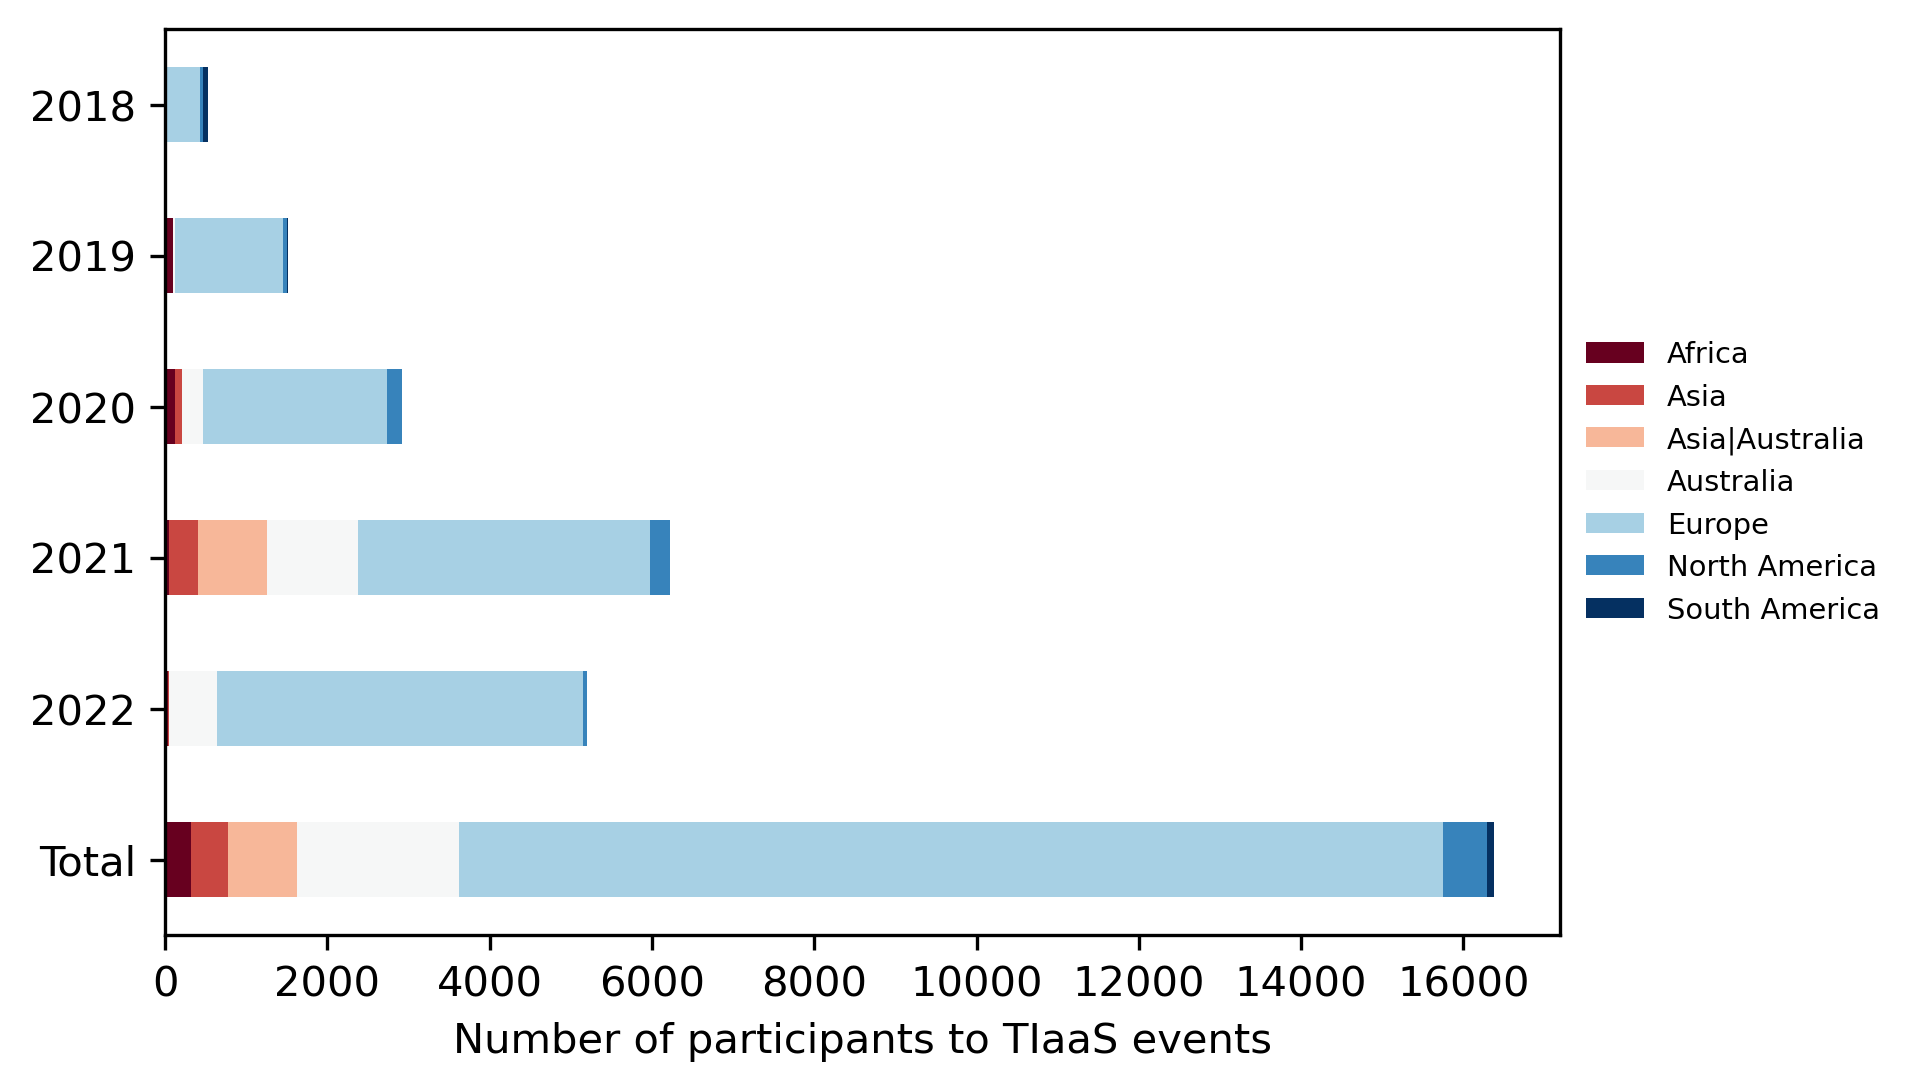

In [13]:
fig, ax = plt.subplots()
fig.set_dpi(300)
(continent_year_participants_df
     .drop(['Total'], axis=1)
     .plot.barh(stacked=True, ax=ax, colormap='RdBu'))
plt.xlabel('Number of participants to TIaaS events')
ax.legend(
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    frameon=False,
    fontsize='x-small')
plt.savefig('../images/tiaas-participants-per-year.png', bbox_inches='tight')